In [1]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
100% 327M/329M [00:01<00:00, 179MB/s]
100% 329M/329M [00:01<00:00, 212MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plant-village.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.python.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 10
CHANNELS = 3
EPOCHS = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
print(class_names)

Found 20638 files belonging to 15 classes.
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


2064

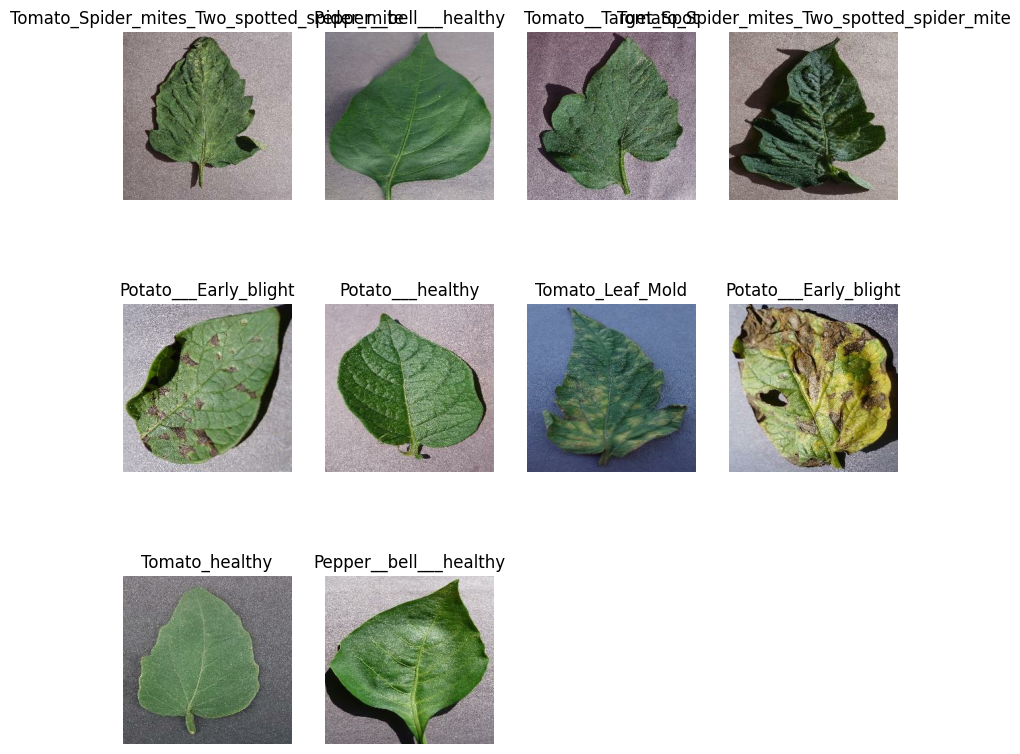

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10): #changed value original is 12
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
len(dataset) #total no of picture batches

In [6]:
train_size = 0.8
len(dataset)*train_size
train_ds = dataset.take(6) #80% of dataset
len(train_ds)
test_ds= dataset.skip(6) #starting from remaining 81st%
val_size = 0.1
len(dataset)*val_size
val_ds = test_ds.take(1)
test_ds = test_ds.skip(1)
len(test_ds)

2057

In [7]:
#ds = dataset
#def get_dataset_partitions_tf(dataset, train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
#  ds_size = len(dataset)
#  if shuffle:
#    dataset = dataset.shuffle (shuffle_size, seed = 12)
#  train_size = int(train_split * ds_size)
#  val_size = int(val_split * ds_size)
#  train_ds = dataset.take(train_size)
#  val_ds = dataset.skip(train_size).take(val_size)
#  test_ds = dataset.skip(train_size).skip(val_size)
#  return

#  train_ds, val_ds, test_ds = get_dataset_Partitions_tf(dataset)

In [8]:
print("Training Image batches:",len(train_ds))
print("Validation Image batches:",len(val_ds))
print("Testing Image batches:",len(test_ds))

Training Image batches: 6
Validation Image batches: 1
Testing Image batches: 2057


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valn_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# Preprocessing Layers
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])


In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    #tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    #tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape = input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (10, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (10, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (10, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (10, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (10, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (10, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (10, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (10, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (10, 12544)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (10, 64)                    │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (10, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.2000 - val_loss: nan
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.2000 - val_loss: nan
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 9/50


In [ ]:
scores = model.evaluate(test_ds)

history.history.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

  78/2057 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.0468 - loss: nan

In [1]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

NameError: name 'plt' is not defined

In [5]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence


In [9]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range (9):
    ax = plt.subplot(3,3, i +1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i].numpy()]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
    plt.axis("off")

NameError: name 'test_ds' is not defined

<Figure size 1500x1500 with 0 Axes>

In [4]:
model_version = 3
model.save(f"Downloads/{model_version}")

NameError: name 'model' is not defined